# SEBAL Model with Meteorological data 
Sebal Model implementation with actual meteorological data and chosen Landsat 8 scenes from MesoHyd Project, Leipzig University. \
Data provided by Christopher Hutengs.
  

In [1]:
# Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rioxarray.merge import merge_arrays
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import math

# Loading geocube to raterize vector polygons (https://github.com/corteva/geocube)
from geocube.api.core import make_geocube

import spyndex
#import earthpy as et
#import earthpy.spatial as es
##import earthpy.plot as ep
import tarfile
import pathlib
#import geowombat




import glob
import os
import os.path
import sys

In [2]:
# Define if plots should be produced: "yes" or "no"
plots = "yes"


In [3]:
# Path Conversion Tool
pathlib.PureWindowsPath(r"D:\Nicolas_D\Geodaten\Masterarbeit\DATA_MesoHyd_MA-SEBAL\Processed\study_area").as_posix()


'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/study_area'

In [4]:
# Insert Start of data directory 
# path_data = "../../DATA_MesoHyd_MA-SEBAL/"   # Path data SC_UL
path_data = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/" # Path data NICOLAS-PC




In [5]:
# ### FOR FASTER WORKING LOAD Landsat Rasterstack

# # Load Cliped and processed raster stack (NetCDF)
# LS_stack_clip = rxr.open_rasterio(path_data + "Processed/LANDSAT/LS_Processed/LS08_20150704.nc")

# # Print Properties with reloaded "new" LS_stack_clip (from NetCDF file)
# #print(LS_stack_clip)
# #print(LS_stack_clip.rio.crs)

# # Fix issues if lost CRS and lat/long dimensions of loaded LS_stack_clip from NetCDF
# #LS_stack_clip = LS_stack_clip.rename({"x": "long", "y": "lat"})
# #LS_stack_clip = LS_stack_clip.sortby(["band", "lat", "long"])
# LS_stack_clip.rio.write_crs("epsg:32632", inplace=True)
# LS_stack_clip = LS_stack_clip.squeeze()

# # Mask any values other than "Clear with low confidence on Clouds"
# LS_stack = LS_stack_clip.where(LS_stack_clip.QA_PIXEL.values == 21824)

In [6]:
# Set date(s) of modelling/data retrieval
date = "2015-07-04"
date = pd.to_datetime(date, format = "%Y-%m-%d")
print("Date normal =", date)
print(type(date))

# Date in meteo_raster_daily Path Format
date_met = date.date()
date_met = date_met.strftime('%Y-%m-%d')
print("Date INTERMET =", date_met)
print(type(date_met))

# Date in WASIM-Raster Path Format
date_wasim = date.date()
date_wasim = date_wasim.strftime('%Y_%m_%d').replace("_0", "_")
print("Date WASIM =", date_wasim)
print(type(date_wasim))

# Date in Landsat Path Format
date_LS = date.date()
date_LS = date_LS.strftime('%Y%m%d')
print("Date Landsat =", date_LS)
print(type(date_LS))

Date normal = 2015-07-04 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Date INTERMET = 2015-07-04
<class 'str'>
Date WASIM = 2015_7_4
<class 'str'>
Date Landsat = 20150704
<class 'str'>


# Import data/Test
Get help/tutorial from https://www.earthdatascience.org/courses/use-data-open-source-python/

### Configure Data Access (Date, ...)

In [7]:
# 0. Path for GeoTIFF
stack_name = "LS08_" + date_LS + ".tif"
stack_path = path_data + "Processed/LANDSAT/LS_Processed/" + stack_name

# Load Shapefile for Catchments
path_shapeA = path_data + "Processed/study_area/altenbamberg_catchment.gpkg"
shape_alten = gpd.read_file(path_shapeA)

path_shapeK = path_data + "Processed/study_area/kellenbach_catchment.gpkg"
shape_kellen = gpd.read_file(path_shapeK)

# Combine both Catchment Shapes
shape_catchments = pd.concat([shape_alten, shape_kellen])

In [8]:
# # Load Cliped and processed Landsat raster stack (GeoTIFF), set CRS and apply Cloud Mask
# #def load_LS_stack():
# LS_stack_clip = rxr.open_rasterio(stack_path)
# LS_stack_clip.rio.write_crs("epsg:32632", inplace=True)
# LS_stack_clip = LS_stack_clip.squeeze()

# # Cloud Mask based on Landsat Quality Assessment Band, only keep "Clear with low confidence on Clouds"
# #LS_stack = LS_stack_clip.where(LS_stack_clip.QA_PIXEL.values == 21824) 
# print("GeoTIFF stack was loaded successfully")

In [9]:
# Open Original Data in .tar archive
path1 = path_data + "Original/LANDSAT"
archive_pattern = f"*{date_LS}*.tar"
archive = sorted(glob.glob(os.path.join(path1, "**", archive_pattern), recursive=True))

# Create Directory for unpacked images
path2 =  path_data + "Processed/LANDSAT/" + "LS08_" + date_LS
path2
#path3 = data[45:-4] # Path for SC_UL
#path3 = data[74:-4]  # Path for NICOLAS-PC

#path_combined = os.path.join(path2, path3)
#path_combined
#os.mkdir(path_combined)

# Unpack .tar archive if Meta file already exists
file_test = glob.glob(path2 + "/*MTL.txt")

if not len(file_test) > 0:
    tar = tarfile.open(archive[0])
    tar.extractall(path = path2)
    tar.close()
    print("tar-archive with GeoTIFFS was unpacked")
else:
    print("tar-archive with GeoTIFFS was already unpacked")

# Open data files
data = sorted(glob.glob(path2 + "/*.TIF"))
data

###############################
# Open Landsat meta data
meta_path = sorted(glob.glob(path2 + "/*MTL.txt"))
meta = pd.read_csv(meta_path[0], sep = "=")

# Extract date and time from Landsat metadata
LS_date = meta[meta.iloc[:,0].str.contains("DATE_ACQUIRED")].iloc[0,1].strip() #.strip() to remove whitespace before string 
LS_time = meta[meta.iloc[:,0].str.contains("SCENE_CENTER_TIME")].iloc[0,1].strip().replace('"', '') 
LS_time = LS_time[0:8]
LS_date_time = LS_date + "-" + LS_time
LS_date_time = pd.to_datetime(LS_date_time, format = "%Y-%m-%d-%H:%M:%S")

###############################
# Extracting scale factors for Bands from Metafile
# Load and convert mutliplicative scale factor
scale_factor = meta[meta.iloc[:,0].str.contains("REFLECTANCE_MULT_BAND_1")].iloc[0,1]
scale_factor = float(scale_factor)
#print("Scale factor =", scale_factor)

# Load and convert additive offset
scale_add = meta[meta.iloc[:,0].str.contains("REFLECTANCE_ADD_BAND_1")].iloc[0,1]
scale_add = float(scale_add)
#print("Additive offset =", scale_add)

# open Metadatafile for extracting scale factors for THERMAL
# Load and convert mutliplicative scale factor for Band 10 (Surface Temp in Kelvin)
scale_factor_thermal = meta[meta.iloc[:,0].str.contains("TEMPERATURE_MULT_BAND_ST_B10")].iloc[0,1]
scale_factor_thermal = float(scale_factor_thermal)
#print("Scale factor Thermal =", scale_factor_thermal)

# Load and convert additive offset for Band 10 (Surface Temp in Kelvin)
scale_add_thermal = meta[meta.iloc[:,0].str.contains("TEMPERATURE_ADD_BAND_ST_B10")].iloc[0,1]
scale_add_thermal = float(scale_add_thermal)
#print("Additive offset Thermal =", scale_add_thermal)

###############################
# Load GeoTIFFs 
stack_dict = dict()

for i in range(2, 9):
    band_i = rxr.open_rasterio(data[i], masked = True).squeeze()
    band_corr = band_i*scale_factor+scale_add
    globals()[f"band_{i-1}"] = band_corr
    #print([f"band_{i-1}"])
    stack_dict[f"band_{i-1}"] = band_corr
    
###############################
# Add other needed bands to dictionary
# Band 10 Surface Temperature
stack_dict["band_10"] = rxr.open_rasterio(data[11], masked = True).squeeze()*scale_factor_thermal+scale_add_thermal

# Thermal Radiance TRAD
stack_dict["band_trad"] = rxr.open_rasterio(data[17], masked = True).squeeze()*0.001

# Emissivity estimated from ASTER_GED
stack_dict["emis"] = rxr.open_rasterio(data[14], masked = True).squeeze()*0.0001

# Level 2 Quality Pixel Band
stack_dict["QA_PIXEL"] = rxr.open_rasterio(data[0], masked = True).squeeze()

# Atmspheric Transmissivity Band
stack_dict["AtmoTrans"] = rxr.open_rasterio(data[10], masked = True).squeeze()*0.0001    

###############################
# Convert dictionaries xarrays into xr.Dataset
LS_stack = xr.Dataset(stack_dict)

###############################    
# Clip Landsat Raster with Shapefile
LS_stack_clip = LS_stack.rio.clip(shape_catchments.geometry, all_touched = True)

###############################  
# Safe cliped and processed raster stack to GeoTIFF Stack
#LS_stack_clip_float32 = LS_stack_clip.astype(np.float32)
#LS_stack_clip_float32.rio.to_raster(raster_path = (path_data + "Processed/LANDSAT/LS_Processed/" + stack_name))


###############################
# Cloud Mask based on Landsat Quality Assessment Band, only keep "Clear with low confidence on Clouds"
LS_stack = LS_stack_clip.where(LS_stack_clip.QA_PIXEL.values == 21824)

print("GeoTIFFs were loaded successfully")

tar-archive with GeoTIFFS was already unpacked


GeoTIFFs were loaded successfully


### Import Landsat 8 data - VIS/NIR

### Quick analysis of Land surface Temperature (Band 10)

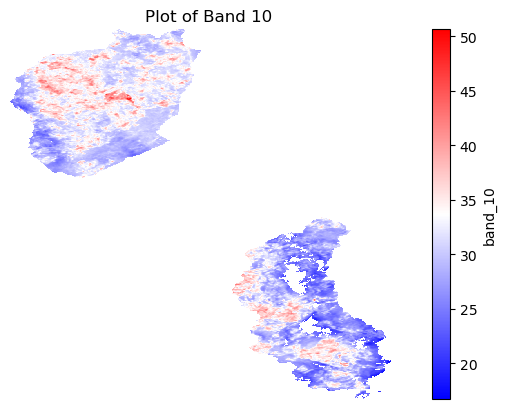

Min: 289.88736 K
Max: 323.78387 K
Min: 16.737366 °C
Max: 50.63388 °C


In [10]:
# T in Celsius

if plots == "yes": 
    band_10_cels = LS_stack.band_10 - 273.15    
    
    # Colormap 
    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["b", "w", "r"], N=256) 
    
    # Plot the data
    f, ax=plt.subplots()
    band_10_cels.plot.imshow(ax=ax,
                  cmap=cmap)
    ax.set_axis_off()
    ax.set_title("Plot of Band 10")
    plt.show()  
    
    # Print max/min T
    print("Min:", np.nanmin(LS_stack.band_10.values), "K")
    print("Max:", np.nanmax(LS_stack.band_10.values), "K")
    print("Min:", np.nanmin(band_10_cels.values), "°C")
    print("Max:", np.nanmax(band_10_cels.values), "°C")





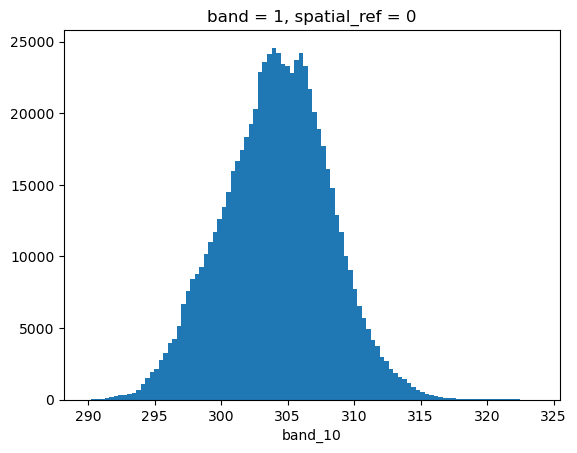

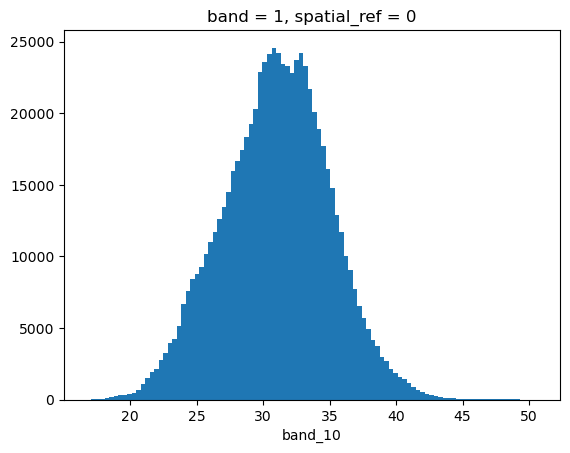

In [11]:
if plots == "yes": 
    LS_stack.band_10.plot.hist(bins = 100)
    plt.show()
    band_10_cels.plot.hist(bins = 100)
    plt.show()

# Processing Steps

## 1. Preprocessing

### 1. Satellite Data: see above

### 2. Land Use Map

In [12]:
# Open Corine Land Use Maps for both catchments
path_LUA = path_data + "Original/study_area/altenuse-ch.tif"
LU_alten = rxr.open_rasterio(path_LUA).squeeze()


path_LUK = path_data + "Original/study_area/kelleuse-ch.tif"
LU_kellen = rxr.open_rasterio(path_LUK).squeeze()

# Merge raster
LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
LU_mosaic .rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = LU_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

LU_mosaic = xds_repr_match


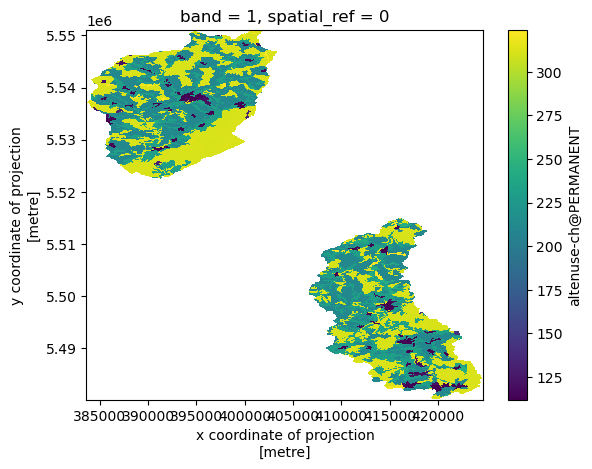

In [13]:
# Merge rasters 
if plots == "yes": 
    LU_mosaic.plot()

In [14]:
# Combine with Land Cover Key Table
LU_table_path = "../data/clc_legend.csv"
LU_table = pd.read_csv(LU_table_path) #delimiter = "\t", header = [3]
print(LU_table)

LU_agri = [211, 212, 221, 222, 223, 241, 242, 243, 244]
LU_bare = [331, 332, 333, 334, 131]
LU_grass = [231, 321, 322, 323, 324, 411, 412]
LU_urban = [111, 112, 121, 122, 123, 124, 132, 133, 141, 142]
LU_forest = [311, 312, 313]
LU_water = [511, 512, 335]

    GRID_CODE  CLC_CODE                         LABEL1  \
0           1       111            Artificial surfaces   
1           2       112            Artificial surfaces   
2           3       121            Artificial surfaces   
3           4       122            Artificial surfaces   
4           5       123            Artificial surfaces   
5           6       124            Artificial surfaces   
6           7       131            Artificial surfaces   
7           8       132            Artificial surfaces   
8           9       133            Artificial surfaces   
9          10       141            Artificial surfaces   
10         11       142            Artificial surfaces   
11         12       211             Agricultural areas   
12         13       212             Agricultural areas   
13         14       213             Agricultural areas   
14         15       221             Agricultural areas   
15         16       222             Agricultural areas   
16         17 

In [15]:
# Create filters from Land Use classes
agri_filter = np.isin(LU_mosaic.values, LU_agri)
bare_filter = np.isin(LU_mosaic.values, LU_bare)
grass_filter = np.isin(LU_mosaic.values, LU_grass)
urban_filter = np.isin(LU_mosaic.values, LU_urban)
forest_filter = np.isin(LU_mosaic.values, LU_forest)
water_filter = np.isin(LU_mosaic.values, LU_water)

### 3. Meteorolocial Data

#### 3.1 Wind
Load and process wind data (Station data, one point per catchment, from WASIM Meteo Data)


C:\Users\nicol\AppData\Local\Temp\ipykernel_15556\4018496343.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wind_day = pd.Series([wind_df.loc[date][1], wind_df.loc[date][0]], index = [0,0])


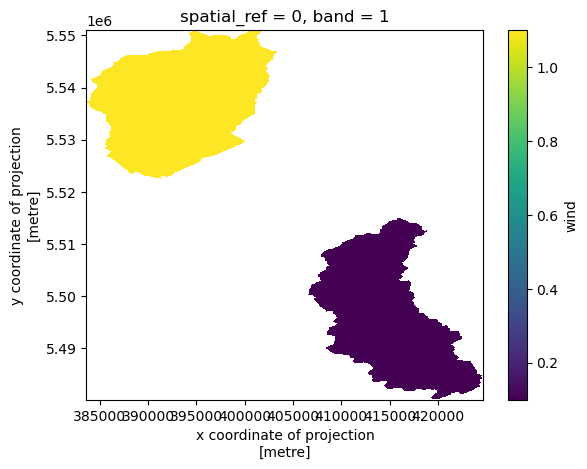

In [16]:
# Read Wind tables from meteo data
path_meteo: str = path_data + "Processed/meteo_original/"
path_wind_alten: str = path_meteo + "Wind2010_alten.txt"
path_wind_kellen: str = path_meteo + "Wind2010_kellen.txt"
wind_alten = pd.read_csv(path_wind_alten, delimiter = "\t", header = [3])
wind_kellen = pd.read_csv(path_wind_kellen, delimiter = "\t", header = [3])

# Change Hour to Start time of day at 00:00 midnight 
wind_alten.iloc[:,3] = wind_alten.iloc[:,3]-1 
wind_kellen.iloc[:,3] = wind_kellen.iloc[:,3]-1 

# Create DateTimeIndex based on Date columns
alten_wind_date_index = pd.to_datetime(wind_alten.iloc[:,0:4].astype(str).agg("-".join, axis = 1), format = "%Y-%m-%d-%H")
kellen_wind_date_index = pd.to_datetime(wind_kellen.iloc[:,0:4].astype(str).agg("-".join, axis = 1), format = "%Y-%m-%d-%H")

# Built final wind dataframe
wind_alten_df = wind_alten.iloc[:,4].to_frame()
wind_kellen_df = wind_kellen.iloc[:,4].to_frame()

# Add Date Index
wind_alten_df = wind_alten_df.set_index([alten_wind_date_index])
wind_kellen_df = wind_kellen_df.set_index([kellen_wind_date_index])

# Outer Join for both data frames Altenbamberg and Kellenbach
wind_df = pd.concat([wind_alten_df, wind_kellen_df], axis = 1)
wind_df.columns = ["wind_altenbamberg", "wind_kellenbach"]
wind_df.index.name = "date"

# Extracting Wind Speed for respective Date and add to map per Catchment
wind_day = pd.Series([wind_df.loc[date][1], wind_df.loc[date][0]], index = [0,0])
wind_vec = shape_catchments.assign(wind = wind_day)

 
    
#################################################    
# Rasterize vector polygon with geocube
out_grid = make_geocube(
    vector_data = wind_vec,
    output_crs = LS_stack.rio.crs,
    resolution = (-30, 30)
)

# Resample raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = out_grid
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

wind_map = xds_repr_match.wind

if plots == "yes": 
    wind_map.plot()    

# Export to csv
# wind_df.to_csv("D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/meteo_processed/wind_velocity.csv")



In [17]:
wind_vec.area / 1000000

0    317.7175
0    361.8075
dtype: float64

## 2. Surface Radiation Balance

### 2.1 NDVI, SAVI, LAI

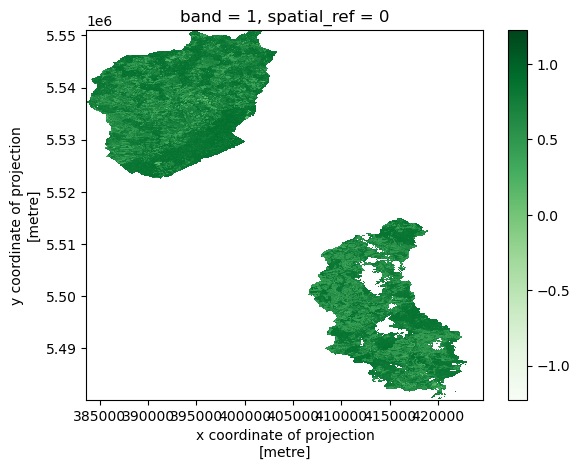

In [18]:
# NDVI
# NDVI = (band_5 - band_4) / (band_5 + band_4)

NDVI = spyndex.computeIndex(
    index = "NDVI",
    params = {
        "N": LS_stack.band_5,
        "R": LS_stack.band_4
    }
)

if plots == "yes": 
    NDVI.plot(cmap = "Greens")

In [19]:
# SAVI
# SAVI = (1+L_savi)*(band_5 - band_4) / (L_savi+band_5 + band_4)
L_savi = 0.5       # Value should be adjusted according to Soil Moisture (0.1 and 0.5 are suggested)

SAVI = spyndex.computeIndex(
    index = "SAVI",
    params = {
        "L": L_savi,
        "N": LS_stack.band_5,
        "R": LS_stack.band_4
    }
)

#### LAI
Calcualtion of LAI based on function from Olmedo et al. 2016 \
*"water: Tools and Functions to Estimate Actual Evapotranspiration Using Land Surface Energy Balance Models in R"*
https://journal.r-project.org/archive/2016/RJ-2016-051/index.html

In [20]:
# Function of LAI 

def LAI_func(method):
    if method == "metric":
        LAI = -(np.log((0.69-SAVI)/0.59)/0.91) 
    elif method == "metric2010":
        LAI = 11*(SAVI**3)
    elif method == "vineyard":
        LAI = 4.9*NDVI-0.46
    elif method == "MCB":
        LAI = 1.2 - 3.08 * np.exp(-2013.35 * NDVI**6.41)
    elif method == "turner":
        LAI = 0.5724 + 0.0989 * NDVI - 0.0114 * NDVI**2 + 0.0004 * NDVI**3
    return(LAI)


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


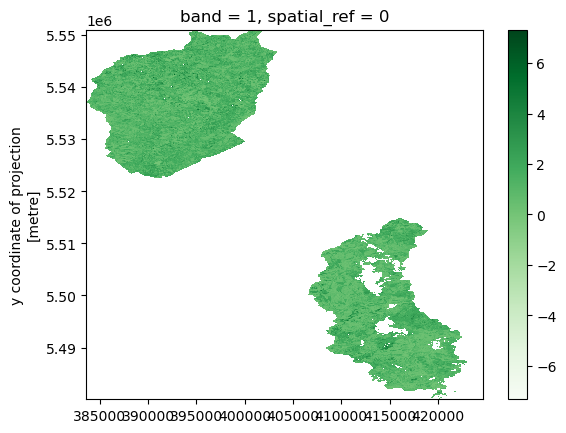

In [21]:
# Calculate LAI with mean of two Formulas after Jaafar_2020
LAI = (LAI_func("metric") + LAI_func("metric2010")) / 2 

if plots == "yes": 
    LAI.plot(cmap = "Greens")
    
if plots == "yes":     
    LAI.plot.hist(bins = 50)

### 2.2 Albedo
Calcualtion of Albedo based on LS 8 BOA Reflectances, based on Olmedo et al. 2016 \
*"water: Tools and Functions to Estimate Actual Evapotranspiration Using Land Surface Energy Balance Models in R"*
https://journal.r-project.org/archive/2016/RJ-2016-051/index.html

In [22]:
# Create band List for Albedo function

def create_band_list(n_bands=7):
  band_list = []
  for i in range(2, n_bands + 1):
    band_name = "band_" + str(i)
    band_list.append(band_name)
  return band_list


# Create a list with names `band_1` to `band_7`
band_list = create_band_list(n_bands=7)

# Function for Albedo with three different coefficient options
def albedo(LS_image, coeff, band_list):
    if coeff == "Tasumi":
        wb = np.array([0.254, 0.149, 0.147, 0.311, 0.103, 0.036])
    elif coeff == "Olmedo":
        wb = np.array([0.246, 0.146, 0.191, 0.304, 0.105, 0.008])
    elif coeff == "Liang":
        wb = np.array([0.356, 0, 0.13, 0.373, 0.085, 0.072])

    # Calculate the albedo for each band.
    albedo = LS_stack[band_list[0]] * wb[0]
    for i in range(1, 6):
            albedo += LS_image[band_list[i]] * wb[i]
            
    return(albedo)

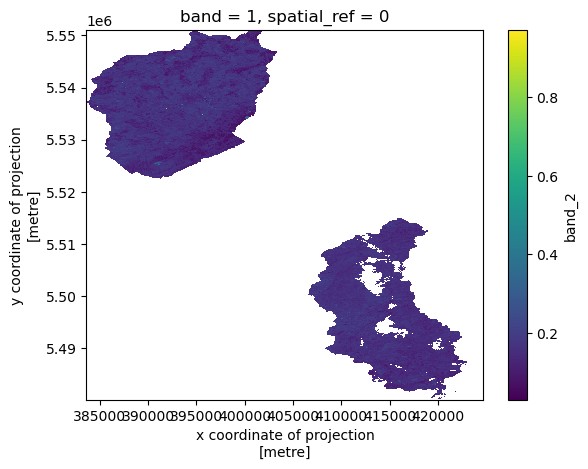

In [23]:
# Calculate Albedo with default coefficients from "Olmedo"
albedo_unfilt = albedo(LS_stack, "Olmedo", band_list)
albedo = albedo_unfilt.where((albedo_unfilt >= 0) & (albedo_unfilt <= 1))

if plots == "yes": 
    albedo.plot()

### 2.3 Rs - Incoming Shortwave Radiation
#### 2.3.1 Easy Formula Approach from SEBAL_manual

In [24]:
# Get specific input data from Landsat Metadata 


# Load and convert mutliplicative scale factor
scale_factor = meta[meta.iloc[:,0].str.contains("REFLECTANCE_MULT_BAND_1")].iloc[0,1]
#scale_factor = float(scale_factor)
#print("Scale factor =", scale_factor)

sun_elev = meta[meta.iloc[:,0].str.contains("SUN_ELEVATION")].iloc[0,1]
sun_elev = float(sun_elev)
solar_inc = 90-sun_elev



In [25]:
# Rs Incoming - Easy Formula Approach from SEBAL_manual
# RS_incoming in W/m²

Gsc = 1367                  # Solar Constant in W/m²

# Solar Incidence Angle 
sun_elev = meta[meta.iloc[:,0].str.contains("SUN_ELEVATION")].iloc[0,1]     # Sun elevation angle in degree, from Metadata_file
sun_elev = float(sun_elev)
solar_inc = 90-sun_elev     # Solar Incidence Angle

# dr
DOY = date.day_of_year                   # DOY based on date from script start
dr = 1+0.033*math.cos(DOY*(2*math.pi/365))  # relative sun-earth-distance dr 

# Atmospheric transmissivity  --> May also possible to use LS_stack.AtmoTrans? But probably band specific 
z = 104     # elevation above sea level (m) for Station (here: Bad Kreuznach elevation) 
tau_sw = 0.75+2*10**-5*z

# RS_incoming in W/m² (should be between 200 and 1000)
RS_in = Gsc * math.cos(solar_inc) * dr * tau_sw
RS_in

843.3475410352578

#### 2.3.2 InterMet bigger raster, hourly
Use of Spatial, hourly Radiation Data from INTERMET (choose time closest to Landsat overpass time) \
**NOTE: Maybe need to correct time (+1h) for meteorological data, because Landsat Aquisition time is GMT --> time zone for InterMet data is yet unknown(?)**

In [26]:
# DATA FROM InterMet/[specific date] --> hourly rasters of radiation

# Date in INTERMET-Raster Path Format with time (hour)
hour = LS_date_time.round("H").strftime("%H")
date_InterMet = date_LS + hour

# Create Path for recursive file search based on defined date
path_intermet = path_data + "Original/InterMet/"
pattern = f"*rad*{date_InterMet}*.tif"
paths_intermet_rad = sorted(glob.glob(os.path.join(path_intermet, "**", pattern), recursive=True))
print(paths_intermet_rad)

# Open INTERMET hourly Radiation Raster (biger area, catchments have to be clipped)
intermet_rad_big = rxr.open_rasterio(paths_intermet_rad[0]).squeeze()
#intermet_rad_big = intermet_rad_big.where(intermet_rad_big > 0)
#intermet_rad_alten = intermet_rad_alten.rename({"x": "long", "y": "lat"})
#intermet_rad_alten = intermet_rad_alten.sortby(["lat", "long"])
intermet_rad_big.rio.write_crs("epsg:31466", inplace=True)
intermet_rad_big.rio.write_nodata(intermet_rad_big.rio.nodata, encoded=True, inplace=True)

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/InterMet\\2015-07-04\\Intermet_hourly_rad_2015070410.tif']


<xarray.DataArray (y: 255, x: 233)>
[59415 values with dtype=float32]
Coordinates:
    band         int32 1
  * x            (x) float64 2.502e+06 2.503e+06 ... 2.733e+06 2.734e+06
  * y            (y) float64 5.669e+06 5.668e+06 ... 5.416e+06 5.415e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  701
    STATISTICS_MEAN:     634.53444297147
    STATISTICS_MINIMUM:  415
    STATISTICS_STDDEV:   27.747302132261
    scale_factor:        1.0
    add_offset:          0.0

In [27]:
# Reproject intermet raster big to same CRS
intermet_rad_big = intermet_rad_big.rio.reproject(LS_stack.rio.crs)
intermet_rad_big = intermet_rad_big.where(intermet_rad_big > 0)

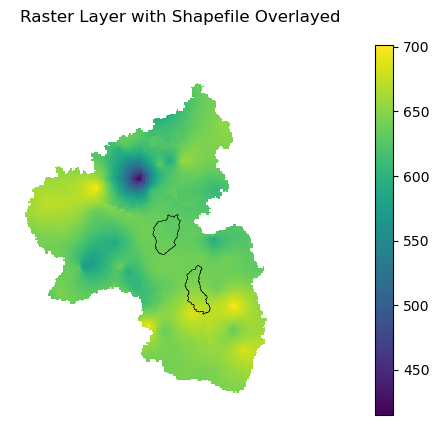

In [28]:
# Plot Catchments within Raster

if plots == "yes": 
    f, ax = plt.subplots()
    intermet_rad_big.plot.imshow(ax=ax)

    shape_catchments.plot(ax=ax,
                        facecolor="none", 
                        linewidth=0.4)
    ax.set(title="Raster Layer with Shapefile Overlayed")


    ax.set_axis_off()
    plt.show()

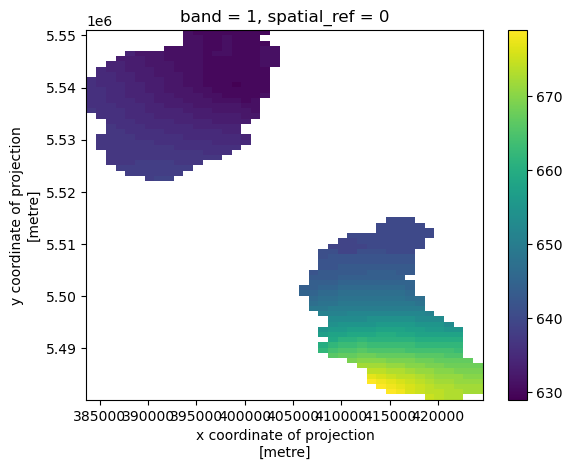

In [29]:
# Clip raster by catchment vectors
intermet_rad_clip = intermet_rad_big.rio.clip(shape_catchments.geometry, all_touched = True)

# Resample rad raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = intermet_rad_clip
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

intermet_rad_clip = xds_repr_match


if plots == "yes": 
    intermet_rad_clip.plot()

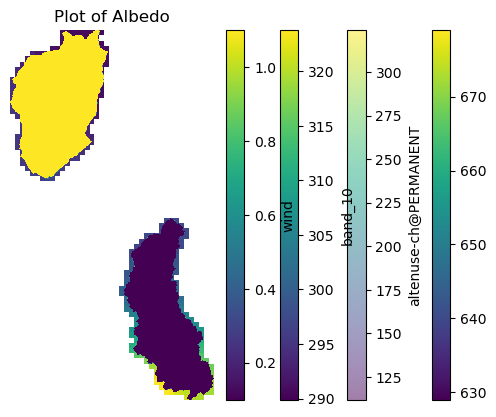

In [30]:
if plots == "yes": 

    # Plot the data - all raster seems to align
    f, ax=plt.subplots()
    intermet_rad_clip.plot.imshow(ax=ax)
    LU_mosaic.plot.imshow(ax=ax, alpha = 0.5)
    LS_stack.band_10.plot.imshow(ax=ax)
    wind_map.plot.imshow(ax=ax)
    ax.set_axis_off()
    ax.set_title("Plot of Albedo")
    plt.show()

### 2.4 RL - Outgoing Longwave Radiation

Surface Emissivity (C, 2.), Thermal Radiance (C, 3.), Surface Temperature (C, 4.) are not needed at the moment because we already got Surface Temperature from Landsat Level 2


In [31]:
if plots == "yes": 
    print("Max LAI:", np.nanmax(LAI.values))

Max LAI: 7.3279047


In [32]:
emis_null = xr.where((LAI < 3) | LAI.isnull(), 0.95 + 0.01*LAI, 0.98)

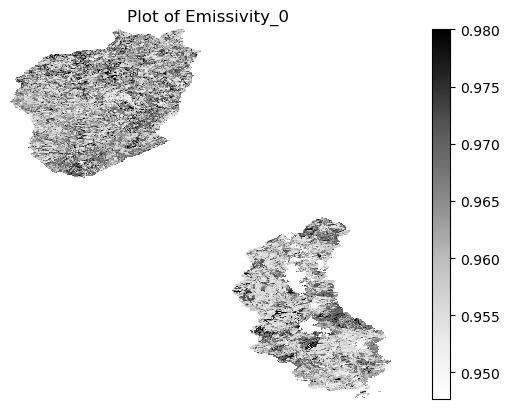

In [33]:
if plots == "yes": 
    # Plot the data
    f, ax=plt.subplots()
    emis_null.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of Emissivity_0")
    plt.show()

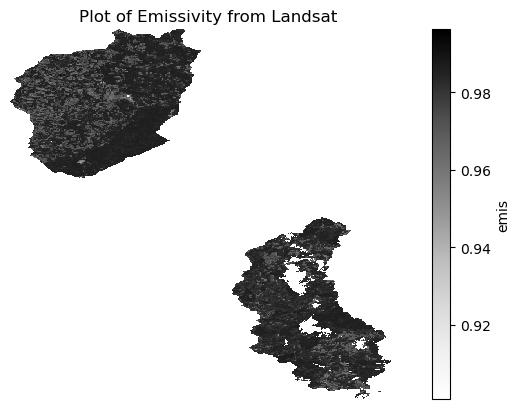

In [34]:
if plots == "yes": 
    # Plot the data
    f, ax=plt.subplots()
    LS_stack.emis.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of Emissivity from Landsat")
    plt.show()

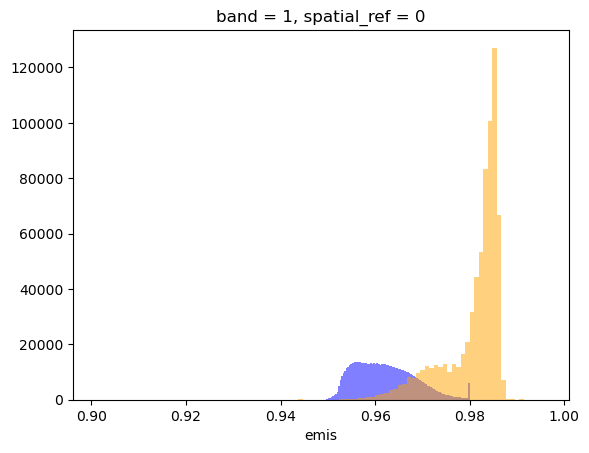

In [35]:
# Further compare both emissivities
if plots == "yes": 
    emis_null.plot.hist(bins = 100, alpha = 0.5, color = "blue")
    LS_stack.emis.plot.hist(bins = 100, alpha = 0.5, color = "orange") # kinda equivalent to emis_narrowband, should be larger than emis_null

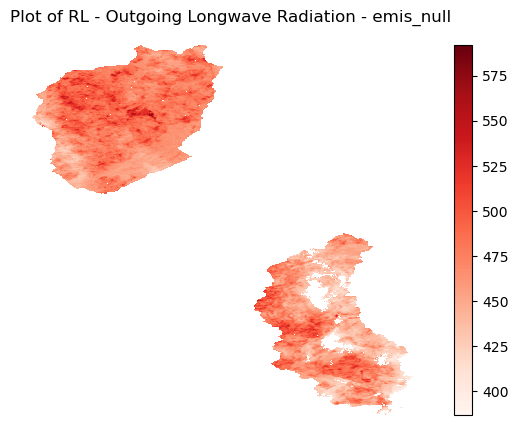

In [36]:
# Outgoing Longwave Radiation
# typical Range: 200-700 W/m²
Ts = LS_stack.band_10    # Surface Temperature in Kelvin 
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4

RL_out = emis_null * sigma * Ts**4     # With emis_null from SEBAL_manual formulas

# Plot the data
if plots == "yes": 
    f, ax=plt.subplots()
    RL_out.plot.imshow(ax=ax,
                    cmap = "Reds")
    ax.set_axis_off()
    ax.set_title("Plot of RL - Outgoing Longwave Radiation - emis_null")
    plt.show()

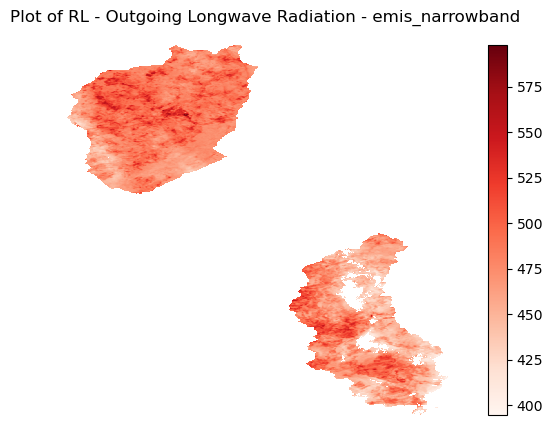

In [37]:
# Outgoing Longwave Radiation
# typical Range: 200-700 W/m²
Ts = LS_stack.band_10    # Surface Temperature in Kelvin 
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4

RL_out_aster = LS_stack.emis * sigma * Ts**4     # With Landsat/ASTER Emissivity, should compare to emis_narrowband (10-11 micrometer)

# Plot the data
if plots == "yes": 
    # Plot the data
    f, ax=plt.subplots()
    RL_out_aster.plot.imshow(ax=ax,
                    cmap = "Reds")

    ax.set_axis_off()
    ax.set_title("Plot of RL - Outgoing Longwave Radiation - emis_narrowband")
    plt.show()

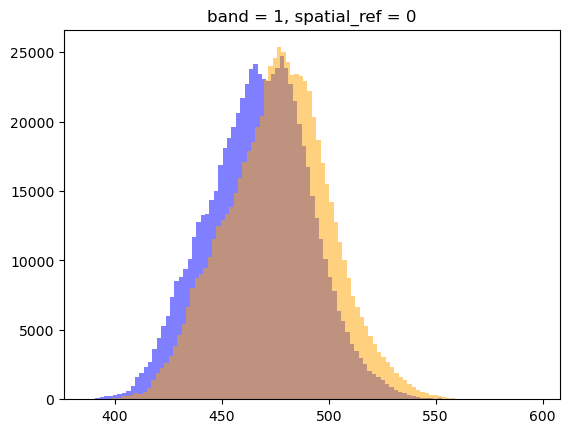

In [38]:
# Further compare both emissivities
if plots == "yes": 
    RL_out.plot.hist(bins = 100, alpha = 0.5, color = "blue") 
    RL_out_aster.plot.hist(bins = 100, alpha = 0.5, color = "orange")     # kinda equivalent to emis_narrowband, should be larger than emis_null

### 2.5 Choosing Hot and Cold Pixel

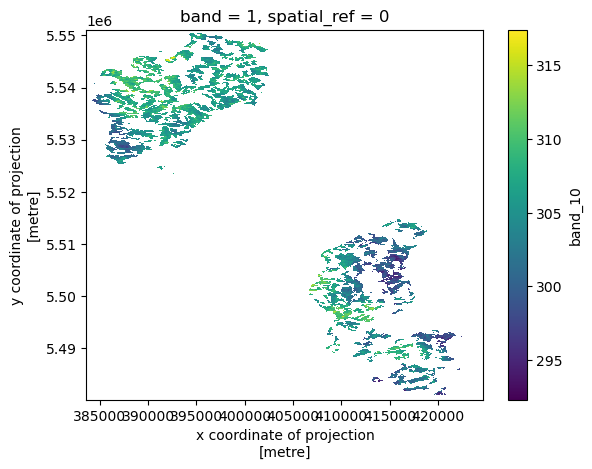

In [39]:
# Selecting Cold/Wet Pixel
cold_px_map = LS_stack.where(agri_filter)
if plots == "yes":     
    cold_px_map.band_10.plot()

T_cold: 293.61642 Land use: 211.0
Overall minimum Ts: 289.88736
T_hot: 317.39557 Land use: 211.0
Overall maximum Ts: 323.78387


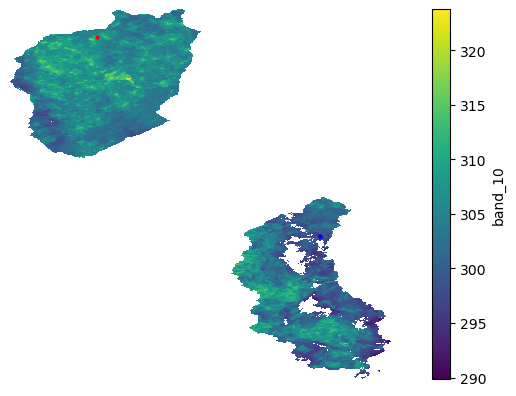

In [44]:
## METHOD AFTER SEBAL_Dissertation_Knoeffel_2018 and SEBAL_manual

LAI_filt = LAI.where(agri_filter)
filt_cold = LS_stack.band_10.where(LAI_filt > 3)
filt_hot = LS_stack.band_10.where(LAI_filt < 1)




# Select cold/wet pixel
T_cold = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().values
cold_x = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().coords["x"].values
cold_y = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().coords["y"].values
LU_cold = LU_mosaic.where(filt_cold==filt_cold.min(), drop=True).squeeze()

print("T_cold:", T_cold, "Land use:", LU_cold.values)
print("Overall minimum Ts:", np.nanmin(LS_stack.band_10.values))


# Selecting Hot/Dry Pixel
T_hot = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().values
hot_x = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().coords["x"].values
hot_y = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().coords["y"].values
LU_hot = LU_mosaic.where(filt_hot==filt_hot.max(), drop=True).squeeze()


print("T_hot:", T_hot, "Land use:", LU_hot.values)
print("Overall maximum Ts:", np.nanmax(LS_stack.band_10.values))



# Plot the data: Hot and Cold Pixel
f, ax=plt.subplots()
LS_stack.band_10.plot()
plt.scatter(cold_x, cold_y, color='blue', s=5)
plt.scatter(hot_x, hot_y, color='red', s=5)
ax.set_axis_off()
ax.set_title("")
plt.show()



In [41]:
# NDVI_filt = NDVI.where(agri_filter)
# zom_px = 0.018*LAI

# # Select cold/wet pixel
# ### ... apply filtering with np.nanpercentile tresholds....
# filt_cold1 = LS_stack.band_10.where(NDVI_filt.values > np.nanpercentile(NDVI_filt, 95))
# filt_cold2 = filt_cold1.where(filt_cold1 < np.nanpercentile(filt_cold1.values, 20))
# filt_cold3 = filt_cold2.where((filt_cold2 >= filt_cold2.mean(skipna = True).values - 0.2) & (filt_cold2 <= filt_cold2.mean(skipna = True).values + 0.2))
# filt_cold4 = filt_cold3.where((albedo >= 0.18) & (albedo <= 0.25))
# filt_cold5 = filt_cold4.where((zom_px >= 0.03) & (zom_px <= 0.08))


# T_cold = filt_cold5.mean()
# cold_x = filt_cold5.where(filt_cold5==filt_cold5.mean(), drop=True).squeeze().coords["x"].values
# cold_y = filt_cold5.where(filt_cold5==filt_cold5.mean(), drop=True).squeeze().coords["y"].values
# LU_cold = LU_mosaic.where(filt_cold5==filt_cold5.mean(), drop=True).squeeze()

# print("T_cold:", T_cold, "Land use:", LU_cold.values)
# print("Overall minimum Ts:", np.nanmin(LS_stack.band_10.values))

    


T_cold: <xarray.DataArray 'band_10' ()>
array(298.23224, dtype=float32)
Coordinates:
    band         int32 1
    spatial_ref  int32 0 Land use: []
Overall minimum Ts: 289.88736


In [42]:
filt_cold4.mean()

<xarray.DataArray 'band_10' ()>
array(298.23224, dtype=float32)
Coordinates:
    band         int32 1
    spatial_ref  int32 0

In [ ]:
# filt_cold3 = fild_cold2.where((fild_cold2 >= filt_cold2.mean(skipna = True).values - 0.2) & (fild_cold2 <= filt_cold2.mean(skipna = True).values + 0.2))

NameError: name 'fild_cold2' is not defined

In [ ]:
# filt_cold2.mean(skipna = True).values + 0.2

298.8524963378906

In [ ]:
# ## METHOD AFTER Allen 2013: Automate Calibration

# NDVI_filt = NDVI.where(agri_filter)

# # Select cold/wet pixel
# ### ... apply filtering with np.nanpercentile tresholds....
# filt_cold = LS_stack.band_10.where(np.nanpercentile(filt_hot.values, 80)

# filt_cold = LS_stack.band_10.where()
# filt_hot = LS_stack.band_10.where(LAI_filt < 1)



# # Select cold/wet pixel
# T_cold = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().values
# cold_x = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().coords["x"].values
# cold_y = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().coords["y"].values
# LU_cold = LU_mosaic.where(filt_cold==filt_cold.min(), drop=True).squeeze()

# print("T_cold:", T_cold, "Land use:", LU_cold.values)
# print("Overall minimum Ts:", np.nanmin(LS_stack.band_10.values))


# # Selecting Hot/Dry Pixel
# T_hot = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().values
# hot_x = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().coords["x"].values
# hot_y = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().coords["y"].values
# LU_hot = LU_mosaic.where(filt_hot==filt_hot.max(), drop=True).squeeze()


# print("T_hot:", T_hot, "Land use:", LU_hot.values)
# print("Overall maximum Ts:", np.nanmax(LS_stack.band_10.values))



# # Plot the data: Hot and Cold Pixel
# f, ax=plt.subplots()
# LS_stack.band_10.plot()
# plt.scatter(cold_x, cold_y, color='blue', s=5)
# plt.scatter(hot_x, hot_y, color='red', s=5)
# ax.set_axis_off()
# ax.set_title("")
# plt.show()



TypeError: DataWithCoords.where() missing 1 required positional argument: 'cond'

### 2.6 RL - Incoming Longwave Radiation

In [45]:
# Incoming Longwave Radiation
# typical Range: 200-500 W/m²
# T_cold = np.nanmin(LS_stack.band_10.values)              # Assuming Tcold is 290 Kelvin, based on band_10 Histogram
Ta = T_cold              # Near Surface Air Temperature in Kelvin from T_cold (T Cold Pixel), since small H --> LST ~ Ta
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4
emis_atmo = 0.85 * (-np.log(tau_sw))**0.09  # Empirical Formula for Atmospheric Emissivity # NOTE: READ on emis_atmo in env.physics page 244

RL_in = emis_atmo * sigma * Ta**4
RL_in

319.92443672959536

Calulated transmissivity 0.75208


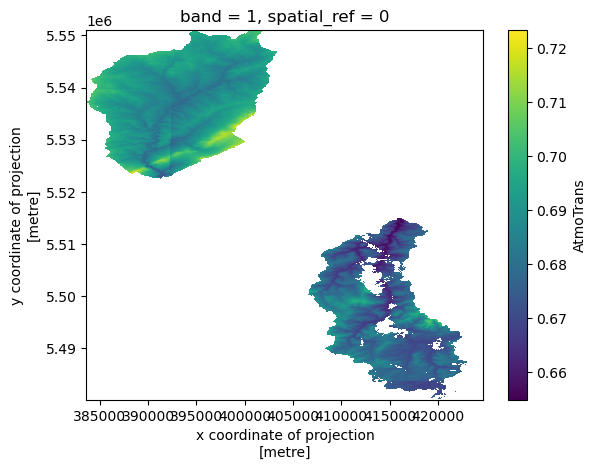

In [46]:
print("Calulated transmissivity", tau_sw)
LS_stack.AtmoTrans.plot()

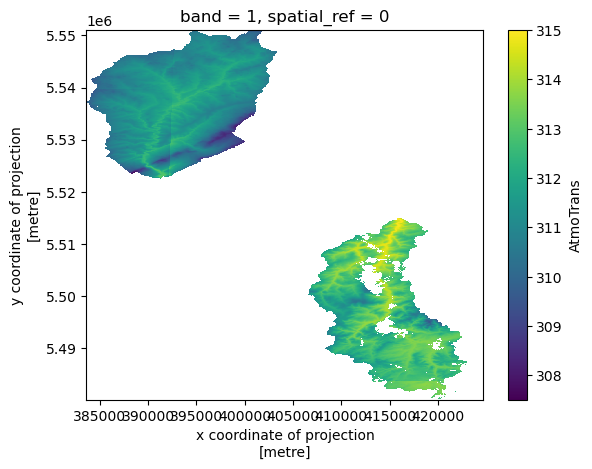

In [47]:
# Try with Landsat 8 L2SP Atmoshperic Transmittance Band for emis_atmo

# Incoming Longwave Radiation
# typical Range: 200-500 W/m²
Tcold = np.nanmin(LS_stack.band_10.values)             # Assuming Tcold is 290 Kelvin, based on band_10 Histogram
Ta = Tcold              # Near Surface Air Temperature in Kelvin from T_cold (T Cold Pixel)
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4
emis_atmo = 0.85 * (-np.log(LS_stack.AtmoTrans))**0.09  # Empirical Formula for Atmospheric Emissivity # NOTE: READ on emis_atmo in env.physics page 244

RL_in_Landsat = emis_atmo * sigma * Ta**4
RL_in_Landsat.plot()

In [ ]:
# Atmospheric emissivity from Env.Physics Book

tair = 300 # Air temperature in Kelvin
emis_atmo_book = 1.72*((math.e/tair)**(1/7))
print(emis_atmo_book)
RL_in_book = emis_atmo_book * sigma * Ta**4
print(RL_in_book)

0.8784075315229108
351.71931936500783


### 2.7 Solving vor Rn

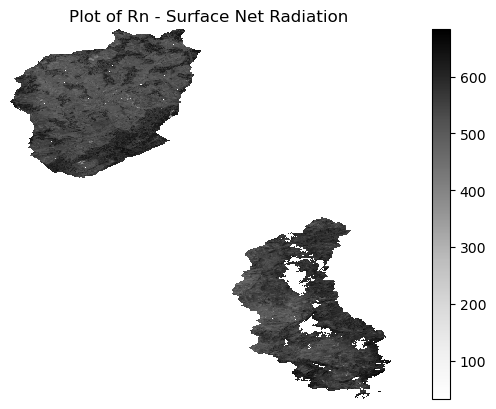

In [48]:
# Solving for Net Surface Radiation Flux Rn
# typical Range: 100-700 W/m²

# Which RL_in to use: 
# 1. RL_in = normal SEBAL Formula  
# 2. RL_in_Landsat = with Landsat AtmoTransmissivity raster
# 3. RLin:book = with Atmospheric emissivity from ENvironmental Physics Book

Rn = (1-albedo)*RS_in + RL_in - RL_out - (1-emis_null)*RL_in  # After SEBAL Manual

# Other Formula based on Allen 2007 / M.L. Fischer Script
# Rn_allen = RS_in - (albedo*RS_in) + RL_in - RL_out - (1-emis_null)*RL_in

Rn = Rn.where(Rn > 0)

if plots == "yes": 
    # Plot the data
    f, ax=plt.subplots()
    Rn.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of Rn - Surface Net Radiation")
    plt.show()

## 3. Surface Energy Balance

### 3.1 G - Soil Heat Flux

In [49]:
# Soil Heat Flux
G_Rn_ratio = ((Ts-273.16)/albedo * ((0.0038*albedo)+(0.0075*(albedo**2)))*(1-0.98*(NDVI**4)))
G = G_Rn_ratio*Rn


print("Min:", np.nanmin(G_Rn_ratio.values))
print("Max:", np.nanmax(G_Rn_ratio.values))

G_Rn_ratio_filt = G_Rn_ratio.where(G_Rn_ratio>0)
G_filt = G.where(G_Rn_ratio>0)

Min: -0.19423479
Max: 0.481108


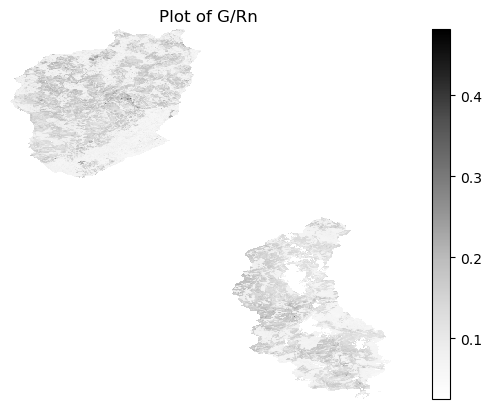

In [50]:
if plots == "yes": 

    # Plot the data
    f, ax=plt.subplots()
    G_Rn_ratio_filt.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of G/Rn")
    plt.show()

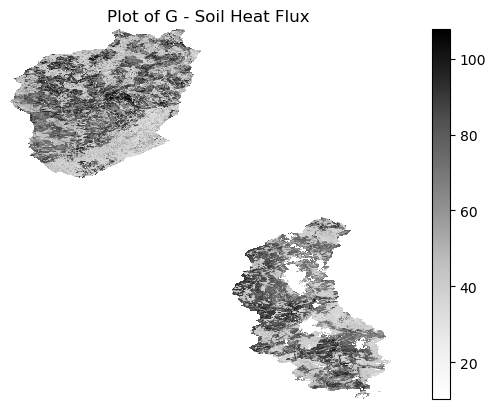

In [51]:
if plots == "yes": 
    # Plot the data
    f, ax=plt.subplots()
    G_filt.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of G - Soil Heat Flux")
    plt.show()

### 3.2 H - Sensible Heat Flux

#### 3.2.1 Aerodynamic Resistance r_ah

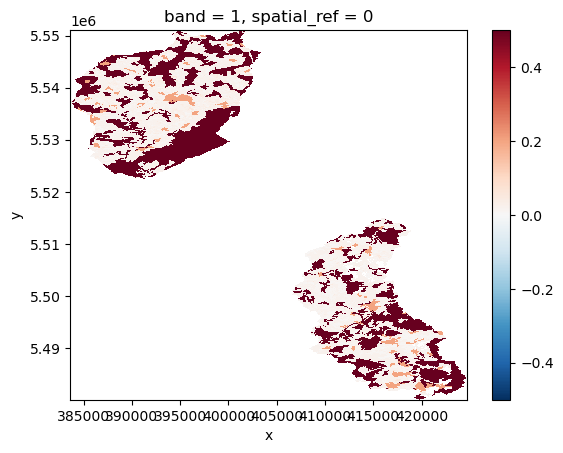

In [65]:
LU_list = [LU_agri, LU_bare, LU_grass, LU_urban, LU_forest, LU_water]
zom_list = [0.018 * LAI, 0.004, 0.02, 0.2, 0.5, 0.001]

zom_map = np.nan  # Default value if none of the conditions match

for i in range(0, len(LU_list)):
    zom_map = xr.where(LU_mosaic.isin(LU_list[i]), zom_list[i], zom_map)
    
if plots == "yes":
    zom_map.plot()

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


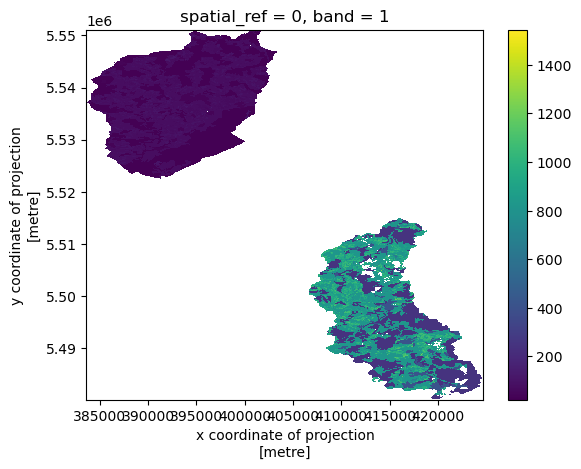

In [66]:
# NEW FORMULA TO CALCULATE with new spatial values of Wind Speed and Land Use based zom, see Zhang_2011_SEBAL/MODIS
# r_ah for neutral stability
# Final Formula: r_ah = (np.log(z2/z1)) / (u_asterix * k)
# Values are just assumed for testing, later taken from actual weather data according to the station
k = 0.41    # Karmans constant

ux = wind_map    # Wind speed at height zx (m/s) 
zx = 2     # Height x with measured Wind speed ux, assumed to be typical weather station height (2m)

# 1. Friction veolocity u_asterix 
u_asterix = (k*ux) / (np.log(zx / zom_map))

# 2. and 3. can be skipped due to already existing wind speed at ground level

# 4. Initial Aerodynamic resistance r_ah
z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual

r_ah = (np.log(z2/z1)) / (u_asterix * k)

if plots == "yes": 
    r_ah.plot()
    



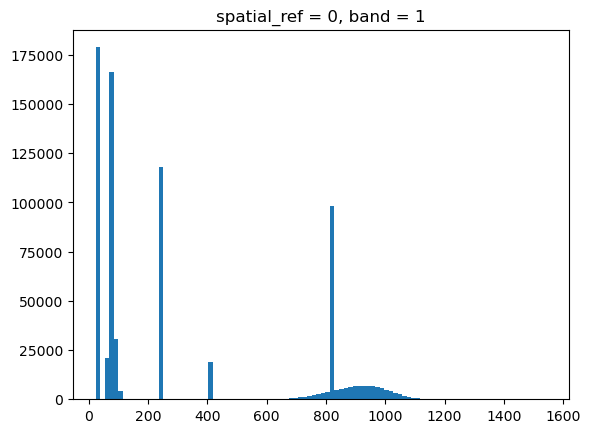

In [54]:
r_ah.plot.hist(bins = 100)
plt.show()

In [67]:
# 11. Add all steps into for loop
# Outside Loop
# COLD PIXEL
# Test with assumption that Hcold = 0 over water bodie with zero sensible heat flux, should be revised with Penman/Monteith ETr
H_cold = 0
dT_cold = 0
Ts_cold = T_cold

# HOT PIXEL
H_hot = Rn.sel(x = hot_x, y = hot_y).values - G.sel(x = hot_x, y = hot_y).values
Ts_hot = T_hot

# Constants 
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
                    # Method after M.L. Fischer: roh_hot = (P *100)/ ((LST - dT) * Rs)
cp = 1004           # Air specific heat (J/kg/K)

Ts_nonan = Ts # .where(((np.isnan(r_ah) == False)), drop = True)

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K

g = 9.81    # Gravitational constant, m/s²

# Create Data Frame to save updated values during iteration
cols = ["Iteration", "r_ah_hot", "dT_hot"]
df_stabcorr = pd.DataFrame(columns=cols, index = range(15))


# Inside Loop

# 5. Compute H from dT (near surface temperature difference)
# Compute H and dT for hot and cold anchor pixels

# Get r_ah for Hot Pixel 
r_ah_hot = r_ah.sel(x = hot_x, y = hot_y).values
dT_hot = H_hot * r_ah_hot / (roh_hot*cp)

# 5.1 Linear Regression on T against dT --> get coeffiients b and a
# Create Arrays for Linear Regression
Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
dT_linreg = np.array([dT_cold, dT_hot.item()])

# Build Linear Model
dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

# Extract Coefficients after dT = b + a*Ts
coeff_b = dT_model.intercept_
coeff_a = dT_model.coef_ 

# 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
dT_pix = coeff_b + coeff_a*Ts_nonan



# 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
Ta_pix = Ts_nonan - dT_pix

roh_pix = pressure / (Rs_constant * Ta_pix)

# 7. Calculate Sensible Heat Flux H with current r_ah
H = (roh_pix * cp * dT_pix) / r_ah

# 8. Stability correction/iteration
# Monin-Obukhov Length L_mo
L_mo = -(roh_pix * cp * u_asterix**3 * Ts) / (k * g * H)

# Filter -inf values
L_mo_ = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)

# Coefficients for Corrections functions below
x_200 = (1-(16*200/L_mo))**0.25
x_2 = (1-(16*2/L_mo))**0.25
x_01 = (1-(16*0.1/L_mo))**0.25

#####################################
# Corections for momentum psi_m and heat transport psi_h 
#####################################
# 1. Correction for psi_m_200
#####################################
# if L_mo < 0
psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
# if L_mo > 0
psi_m_200_pos = -5*(2/L_mo)

psi_m_200 = L_mo    
psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

#####################################
# 2. Correction for psi_h_2
#####################################
# if L_mo < 0
psi_h_2_neg = 2*np.log((1+x_2**2)/2)
# if L_mo > 0
psi_h_2_pos = -5*(2/L_mo)

psi_h_2 = L_mo    
psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 

#####################################
# 3. Correction for psi_h_01
#####################################
# if L_mo < 0
psi_h_01_neg = 2*np.log((1+x_01**2)/2)
# if L_mo > 0
psi_h_01_pos = -5*(0.1/L_mo)

psi_h_01 = L_mo    
psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 

#####################################
cal
# 9. UPDATE u and r_ah: Calculate corrected Friction Velocity u_asterix / 
u_asterix = (k*ux) / (np.log(zx/zom_map) - psi_m_200)

# 10. UPDATE u and r_ah: Corrected Areodynamic Resistance r_ah is calculated
r_ah = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix * k)

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [55]:
# 11. Add all steps into for loop
# Outside Loop
# COLD PIXEL
# Test with assumption that Hcold = 0 over water bodie with zero sensible heat flux, should be revised with Penman/Monteith ETr
H_cold = 0
dT_cold = 0
Ts_cold = T_cold

# HOT PIXEL
H_hot = Rn.sel(x = hot_x, y = hot_y).values - G.sel(x = hot_x, y = hot_y).values
Ts_hot = T_hot

# Constants 
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
                    # Method after M.L. Fischer: roh_hot = (P *100)/ ((LST - dT) * Rs)
cp = 1004           # Air specific heat (J/kg/K)

Ts_nonan = Ts # .where(((np.isnan(r_ah) == False)), drop = True)

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K

g = 9.81    # Gravitational constant, m/s²

# Create Data Frame to save updated values during iteration
cols = ["Iteration", "r_ah_hot", "dT_hot"]
df_stabcorr = pd.DataFrame(columns=cols, index = range(15))


# Inside Loop
for i in range(15):
    # 5. Compute H from dT (near surface temperature difference)
    # Compute H and dT for hot and cold anchor pixels
    
    # Get r_ah for Hot Pixel 
    r_ah_hot = r_ah.sel(x = hot_x, y = hot_y).values
    dT_hot = H_hot * r_ah_hot / (roh_hot*cp)
    
    # 5.1 Linear Regression on T against dT --> get coeffiients b and a
    # Create Arrays for Linear Regression
    Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
    dT_linreg = np.array([dT_cold, dT_hot.item()])

    # Build Linear Model
    dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

    # Extract Coefficients after dT = b + a*Ts
    coeff_b = dT_model.intercept_
    coeff_a = dT_model.coef_ 
    
    # 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
    dT_pix = coeff_b + coeff_a*Ts_nonan
    
    
    
    # 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
    Ta_pix = Ts_nonan - dT_pix

    roh_pix = pressure / (Rs_constant * Ta_pix)

    # 7. Calculate Sensible Heat Flux H with current r_ah
    H = (roh_pix * cp * dT_pix) / r_ah
    
    # 8. Stability correction/iteration
    # Monin-Obukhov Length L_mo
    L_mo = -(roh_pix * cp * u_asterix**3 * Ts) / (k * g * H)
    
    # Filter -inf values
    L_mo_ = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)
    
    # Coefficients for Corrections functions below
    x_200 = (1-(16*200/L_mo))**0.25
    x_2 = (1-(16*2/L_mo))**0.25
    x_01 = (1-(16*0.1/L_mo))**0.25

    #####################################
    # Corections for momentum psi_m and heat transport psi_h 
    #####################################
    # 1. Correction for psi_m_200
    #####################################
    # if L_mo < 0
    psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
    # if L_mo > 0
    psi_m_200_pos = -5*(2/L_mo)

    psi_m_200 = L_mo    
    psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
    psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

    #####################################
    # 2. Correction for psi_h_2
    #####################################
    # if L_mo < 0
    psi_h_2_neg = 2*np.log((1+x_2**2)/2)
    # if L_mo > 0
    psi_h_2_pos = -5*(2/L_mo)

    psi_h_2 = L_mo    
    psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
    psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 
    
    #####################################
    # 3. Correction for psi_h_01
    #####################################
    # if L_mo < 0
    psi_h_01_neg = 2*np.log((1+x_01**2)/2)
    # if L_mo > 0
    psi_h_01_pos = -5*(0.1/L_mo)

    psi_h_01 = L_mo    
    psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
    psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 
    
    #####################################
    
    # 9. UPDATE u and r_ah: Calculate corrected Friction Velocity u_asterix / 
    u_asterix = (k*ux) / (np.log(zx/zom_map) - psi_m_200)
    
    # 10. UPDATE u and r_ah: Corrected Areodynamic Resistance r_ah is calculated
    r_ah = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix * k)
    
    # Save values to Stability Correction DataFrame
    df_stabcorr.loc[i].Iteration = i
    df_stabcorr.loc[i].r_ah_hot = r_ah_hot
    df_stabcorr.loc[i].dT_hot = dT_hot
    

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


ValueError: Input y contains NaN.

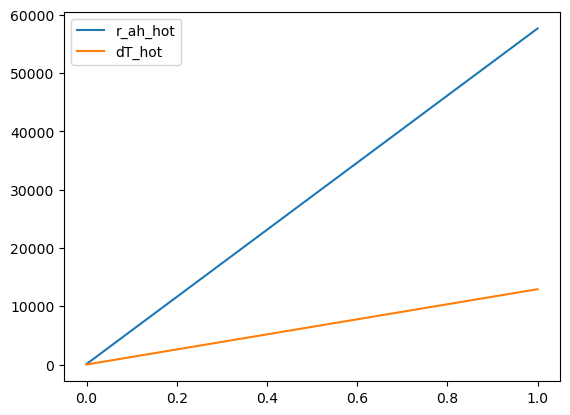

In [210]:
# Plot Change in Stability correction values
plt.plot(df_stabcorr.r_ah_hot, label = df_stabcorr.columns[1])
plt.plot(df_stabcorr.dT_hot, label = df_stabcorr.columns[2])
plt.legend()
plt.show()

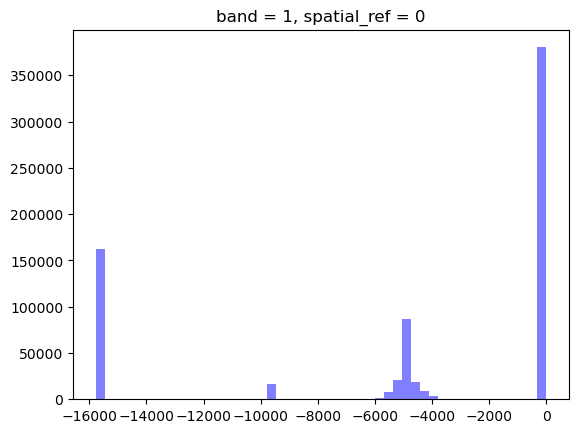

In [156]:
H.plot.hist(bins = 50, alpha = 0.5, color = "blue")
plt.show()

In [182]:
r_ah.sel(x = hot_x, y = hot_y).values

array(1.92857422e+13)

### 3.3 ET - Latent Heat Flux

In [157]:
# Quick and Dirty Calculation of ET (to this point without iterative correction)
ETL = Rn - G_filt - H
ETL = ETL.where(ETL>=0)



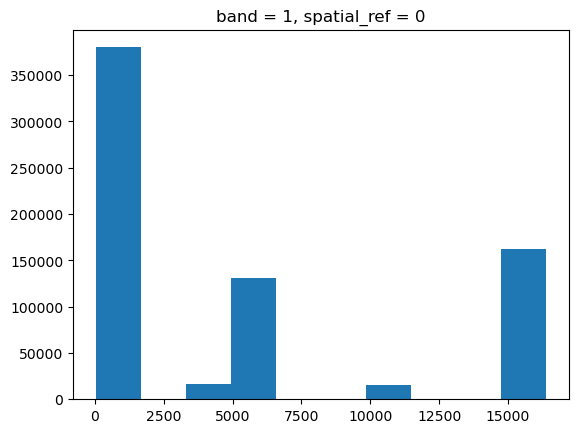

In [158]:
ETL.plot.hist()
plt.show()

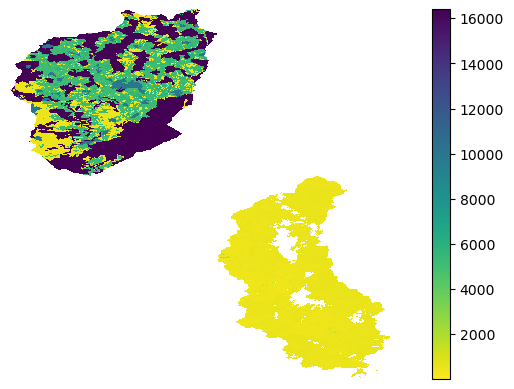

In [159]:
# Plot the data
f, ax=plt.subplots()
ETL.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

(array([3.80071e+05, 6.06000e+02, 1.69100e+04, 1.31482e+05, 3.44000e+02,
        3.55000e+02, 1.58850e+04, 0.00000e+00, 0.00000e+00, 1.62287e+05]),
 array([ 0.03506581,  2.65440144,  5.27373707,  7.8930727 , 10.51240833,
        13.13174396, 15.75107959, 18.37041522, 20.98975085, 23.60908648,
        26.22842211]),
 <BarContainer object of 10 artists>)

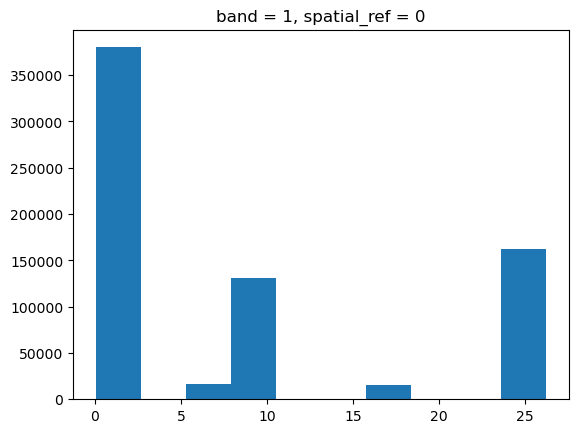

In [160]:
# From ET_lambda to ET in mm/hour
lamda = 2.25 * 10**6 # Latet heat of Vaporization J/kg
ET_inst = 3600* (ETL / lamda)

ET_inst.plot.hist()

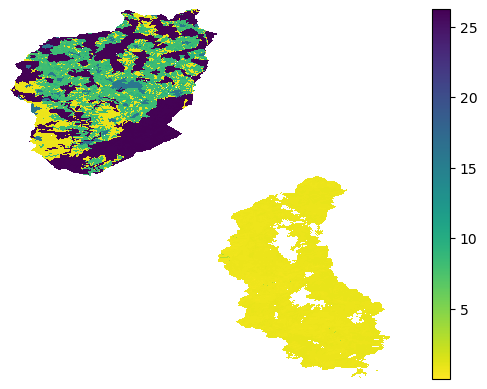

In [161]:
# Plot the data
f, ax=plt.subplots()
ET_inst.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

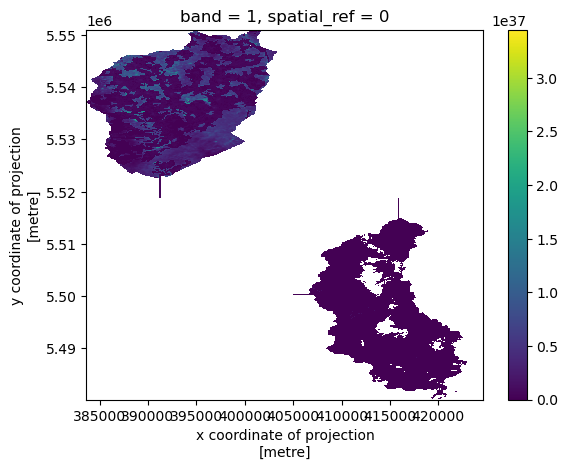

In [162]:
r_ah.plot()